# **Finding Lane Lines on the Road** 

Let's develop a pipeline and first apply it to a series of individual images, and later apply the result to a video stream (really just a series of images).  

The tools we are using here are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  

## Reflections

Make the pipeline works for the lates video was challenge! I know there is always improvements that can be done but I am really happy with final results!!

At the beginning it was easier, I had already some helper functions such as Canny detection and lines drawing. Mathematically, I had a clear plan in my mind by just splitting the cloud of point to left and right lines using slope trhesholds, than a linear regression to fit the final lines. I have followed the plan, got some hard time coding and debugging, then I saw bad results on image and movies!

I have spent some time trying new lines selection and fit methods, always ending up with bad final lines. Then I realize that in fact the problem was not with those fit and selections methods but with my Hough Transform parameters!!! My initial parameters seemed to be reasonable by in fact were not generating good segments of lines for use.

Well, after a better tune with Hough Transform parameter, things improved a lot. Next, I noted that I would need to find a way to get rid of outliers points, I've implemented that by comparing point variation with a factor of total standard variation. At this point things were looking good, until I try the challenge movie!! What a difference between the first 2 and the challenge! Shadow on the floor and other contrasts were messing up with Canny detection. So, the next step was to find a way to mask the image with white and yellow collors before convert to gray scale and load into Canny detection, the trade-off for better quality detection was the insertion of color constrains into the lane system detection.

Played the movies again, and one last thing was clearly showing. The need to play with the vertices of the mask with respect to the image dimensions.  The challenge movie was totally out of frame, when I used the initial vertices setup. The solution was to input bottom, top and height of trapezoid as ratio of original image dimensions, display on screen masked region of movies to better visualize and tune the ratios.

I have stopped here to deliver first project submission. Sure there is a lot possible improvements that can be done, such as line curvature to follow the curvature of the real lane lines, or better techniques to draw fancier lines on image, etc. For curvature I would try first a polynomial fit of the points instead linear and see what would happen. May be later in the future, back to this project!

Well, overall it was a relly good Project, learned quit a bit!

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


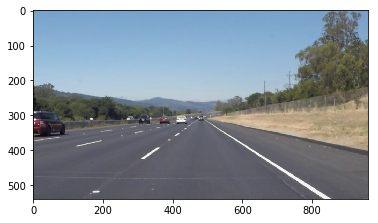

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [12]:
# Helpers functions
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def filter_WhiteYellow(image):
    """
    Filter the image, showing only a range of white and yellow
    """
    # Filter White
    threshold = 200 
    high_threshold = np.array([255, 255, 255]) #Bright white
    low_threshold = np.array([threshold, threshold, threshold]) #Soft White
    mask = cv2.inRange(image, low_threshold, high_threshold)
    white_img = cv2.bitwise_and(image, image, mask=mask)

    # Filter Yellow
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #Changing Color-space, HSV is better for object detection
    #For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. 
    high_threshold = np.array([110,255,255]) #Bright Yellow
    low_threshold = np.array([90,100,100]) #Soft Yellow   
    mask = cv2.inRange(hsv_img, low_threshold, high_threshold)
    yellow_img = cv2.bitwise_and(image, image, mask=mask)

    # Combine the two above images
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

def trapezoid_vertices(image, bottom_width=0.85,top_width=0.07,height=0.40):
    """
    Create trapezoid vertices for mask. 
    Inpus:
    image
    bottom_width = percentage of image width
    top_width = percentage of image width
    height = percentage of image height
    """   
    imshape = image.shape
    
    vertices = np.array([[\
        ((imshape[1] * (1 - bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - top_width)) // 2, imshape[0] *(1 - height)),\
        (imshape[1] - (imshape[1] * (1 - top_width)) // 2, imshape[0] * (1 - height)),\
        (imshape[1] - (imshape[1] * (1 - bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    
    return vertices


def get_left_right_lines(lines,right_limts=[np.tan(20*np.pi/180), np.tan(60*np.pi/180)],
                     left_limts=[np.tan(-60*np.pi/180),np.tan(-20*np.pi/180)]):
    """
    Get left and right lines based on slope. Reduce outliers.
    """  

    # Identify left and right lines
    # Initialize Least squares polynomial fit vector for all Hough lines
    fit = np.zeros((lines.shape[0],2))
    # Iterate over the Hough Lines
    line_counter = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            fit[line_counter] = np.polyfit((x1, x2), (y1, y2), 1)
            line_counter += 1

    # Split lines based on slopes defined limits
    left_lines = lines[np.where( (fit[:,0] > left_limts[0])  &  (fit[:,0] < left_limts[1]))]
    right_lines = lines[np.where( (fit[:,0] > right_limts[0])  &  (fit[:,0] < right_limts[1]))]

    # Drop outliers, play here with "m"
    def reject_outliers(data, m=2):
        return data[abs(data[:,0,0] - np.mean(data[:,0,0])) < m * np.std(data[:,0,0])]

    m = 1
    new_left_lines = reject_outliers(left_lines, m)
    new_right_lines = reject_outliers(right_lines, m)

    return new_left_lines, new_right_lines


def apply_linear_regression(left_lines, right_lines):
    """
    Apply linear regression and fit final left and right lines
    """  

    # Get cloud of left points
    x = np.zeros(2*left_lines.shape[0])
    y = np.zeros(2*left_lines.shape[0])
    line_counter = 0
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            x[line_counter] = x1
            x[line_counter+1] = x2
            y[line_counter] = y1
            y[line_counter+1] = y2
            line_counter += 2

    #linear regression
    if np.sum(x) != 0:
        left_coef = np.polyfit(x,y,1)
    else:
        left_coef = [0,0]


    # Get cloud of Right points
    x = np.zeros(2*right_lines.shape[0])
    y = np.zeros(2*right_lines.shape[0])
    line_counter = 0
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            x[line_counter] = x1
            x[line_counter+1] = x2
            y[line_counter] = y1
            y[line_counter+1] = y2
            line_counter += 2

    #linear regression
    if np.sum(x) != 0:
        right_coef = np.polyfit(x,y,1)
    else:
        right_coef = [0,0]

    return left_coef, right_coef


def extrapolate_lines(image, vertices, left_coef, right_coef):
    """
    Extrapolate final lines in a mask
    """  
    imshape = image.shape
    
    # End points of the line within mask
    if np.sum(left_coef) != 0:
        x1 = int((imshape[0]-left_coef[1])/left_coef[0])
        y1 = int(imshape[0])
        x2 = int((vertices[0,1,1]-left_coef[1])/left_coef[0])
        y2 = int(vertices[0,1,1])
        left_l = np.array([[[x1,y1,x2,y2]]])
    else:
        left_l = np.array([[[0,0,0,0]]],dtype=np.int32)

    # End points of the line within mask
    if np.sum(right_coef) != 0:
        x1 = int((imshape[0]-right_coef[1])/right_coef[0])
        y1 = int(imshape[0])
        x2 = int((vertices[0,1,1]-right_coef[1])/right_coef[0])
        y2 = int(vertices[0,1,1])
        right_l = np.array([[[x1,y1,x2,y2]]])
    else:
        right_l = np.array([[[0,0,0,0]]],dtype=np.int32)

    # Prepare to draw on top of image  
    lines = np.concatenate((left_l, right_l))
    
    # Draw Lines on top of image    
    line_img = np.copy((image)*0)
    draw_lines(line_img, lines, thickness=10)
    line_img = region_of_interest(line_img, vertices)
    final = weighted_img(line_img, image)
    
    return final

## Test on Images

Let's build and test our pipeline to work on the images in the directory "test_images"  
**Let's make sure our pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

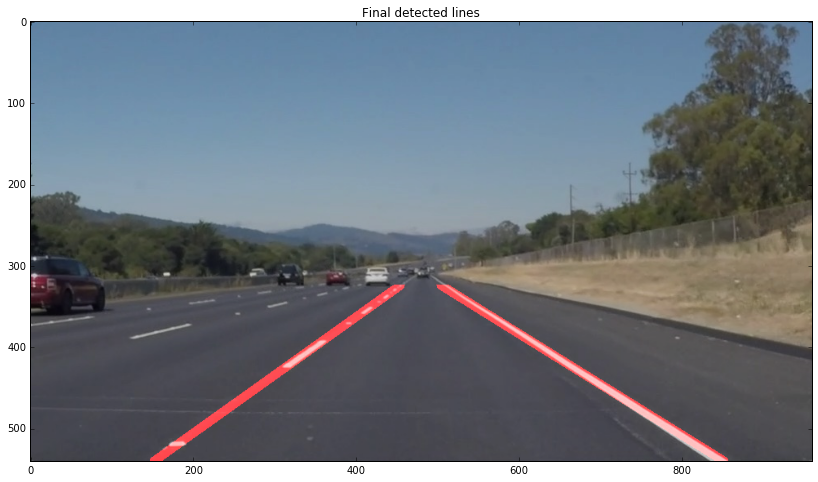

In [13]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Filter white and Yellow to make it easier for more accurate Canny detection
filtered_img = filter_WhiteYellow(image)
# Convert image to gray scale
gray = grayscale(filtered_img)

# Define a kernel size and apply Gaussian smooting / blurring
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Define parameters and run Canny Edge Detection
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

# Create vertices that define mask for Region of interest
vertices = trapezoid_vertices(image, bottom_width=0.85,top_width=0.07,height=0.40)

# Crete mask and apply to Canny Edge Detected image
masked_edges = region_of_interest(edges, vertices)

# Define the Houghh transform parameters
rho = 0.2 #1 pixel
theta = np.pi/300 #1deg in radians
threshold = 5 #mn number of votes at intersections
min_line_len = 50
max_line_gap = 200 #min distance between points

# Run Hough on edge detected image and Draw lines on image
line_img, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

# Define limits to split left and Right Lines
right_limts = [np.tan(20*np.pi/180), np.tan(60*np.pi/180)]
left_limts = [np.tan(-60*np.pi/180),np.tan(-20*np.pi/180)]

# Identify left and right lines. 
left_lines, right_lines = get_left_right_lines(lines, right_limts, left_limts)

# Apply linear regression on selected lines
left_coef, right_coef = apply_linear_regression(left_lines, right_lines)

# Get final extrapolated lines on top of original image
final = extrapolate_lines(image, vertices, left_coef, right_coef)


# Display Image
f, ax = plt.subplots(figsize=(14,8))
ax.imshow(final) 
ax.set_title('Final detected lines')


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two available videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [4]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below

    # Filter white and Yellow to make it easier for more accurate Canny detection
    filtered_img = filter_WhiteYellow(image)
    # Convert image to gray scale
    gray = grayscale(filtered_img)

    # Define a kernel size and apply Gaussian smooting / blurring
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define parameters and run Canny Edge Detection
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Create vertices that define mask for Region of interest
    vertices = trapezoid_vertices(image, bottom_width=0.85,top_width=0.07,height=0.40)

    # Crete mask and apply to Canny Edge Detected image
    masked_edges = region_of_interest(edges, vertices)

    # Define the Houghh transform parameters
    rho = 0.2 #1 pixel
    theta = np.pi/300 #1deg in radians
    threshold = 5 #mn number of votes at intersections
    min_line_len = 50
    max_line_gap = 200 #min distance between points

    # Run Hough on edge detected image and Draw lines on image
    line_img, lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    # Define limits to split left and Right Lines
    right_limts = [np.tan(20*np.pi/180), np.tan(60*np.pi/180)]
    left_limts = [np.tan(-60*np.pi/180),np.tan(-20*np.pi/180)]

    # Identify left and right lines. 
    left_lines, right_lines = get_left_right_lines(lines, right_limts, left_limts)

    # Apply linear regression on selected lines
    left_coef, right_coef = apply_linear_regression(left_lines, right_lines)

    # Get final extrapolated lines on top of original image
    final = extrapolate_lines(image, vertices, left_coef, right_coef)
    
    return final

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 23.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 10.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:29<00:00, 23.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 30.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Final Challenge!

Let's try our lane finding pipeline on the video below.  Does it still work?

In [18]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:18<00:00, 13.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 20.7 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))